In [0]:
import torch
print(torch.__version__)

1.4.0


In [0]:
!pip install -q folium==0.2.1
!pip install -q imgaug==0.2.5
!pip install -q pandas
!pip install -q numpy==1.16.0

     |████████████████████████████████| 71kB 9.4MB/s 
     |████████████████████████████████| 563kB 28.5MB/s 
     |████████████████████████████████| 17.3MB 174kB/s 


In [0]:
!pip install -q pandas
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag

!pip install -q Pillow==4.3.0
!pip install -q PIL
!pip install -q image
import PIL

#%reload_ext autoreload        <------------— comment out 
#%autoreload 0                 <------------— comment out
%matplotlib inline

!pip install --no-cache-dir -I pillow

def register_extension(id, extension):
    PIL.Image.EXTENSION[extension.lower()] = id.upper()
PIL.Image.register_extension = register_extension
def register_extensions(id, extensions):
    for extension in extensions:
        register_extension(id, extension)
PIL.Image.register_extensions = register_extensions

from PIL import Image
def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
Image.register_extension = register_extension
def register_extensions(id, extensions): 
  for extension in extensions: register_extension(id, extension)
Image.register_extensions = register_extensions

     |████████████████████████████████| 5.8MB 44.2MB/s 
     |████████████████████████████████| 112kB 62.6MB/s 
ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL
     |████████████████████████████████| 2.1MB 25.6MB/s 


In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive 
!google-drive-ocamlfuse drive

import os
#os.listdir('/content/drive/AMD/CNV')
#trainDir = '/content/drive/My Drive/AMD/CNV'

from google.colab import drive
drive.mount('/content/drive')
data = "/content/drive/My Drive/Plant Disease/PlantVillage"

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 144568 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.19-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.19-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.19-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [0]:
import torch
import helper
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.models as models

from torchvision import datasets ,transforms


#Changning the transform of the data-
transform_train = transforms.Compose([transforms.RandomHorizontalFlip(),
                                     transforms.RandomResizedCrop(224),
                                     # transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])

transform_test = transforms.Compose([transforms.RandomHorizontalFlip(),
                                     transforms.RandomResizedCrop(224),
                                     # transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])

# choose the training and test datasets
train_data = datasets.ImageFolder(data+"/train", transform=transform_train)
test_data = datasets.ImageFolder(data+"/val", transform = transform_test)
#n_classes = test_data.shape[1]
n_classes = len(test_data.classes)
print(n_classes)

batch_size = 16

dataloader_train = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True, num_workers=2)
dataloader_test = torch.utils.data.DataLoader(test_data, batch_size, num_workers=2)

39


In [0]:
import matplotlib.pyplot as plt
import numpy as np

norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

def imshow_numpy(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    ax.grid(False)
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array(norm_mean)
    std = np.array(norm_std)
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

torch.Size([16, 3, 224, 224])


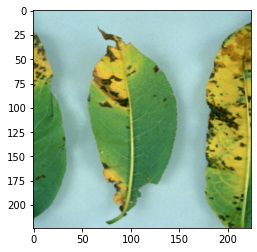

In [0]:
images, labels = next(iter(dataloader_train))
imshow_numpy(images[0].numpy())
print(images.shape)

In [0]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [0]:
import torch
import helper
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.models as models
model = models.vgg16(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Epoch: 1 	Training Loss: 0.707927 	Validation Loss: 0.429423
Validation loss decreased (inf --> 0.429423).  Saving model ...
tensor([[3.6700e+02, 1.5000e+01, 9.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.6000e+01, 4.0600e+02, 2.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [7.0000e+00, 0.0000e+00, 1.5100e+02,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 1.8500e+02, 1.0000e+00,
         0.0000e+00],
        [5.0000e+00, 3.0000e+00, 0.0000e+00,  ..., 1.1000e+01, 1.3240e+03,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         6.9100e+02]])
Class 0
TP 367.0, TN 54521.0, FP 131.0, FN 269.0
Recall = 0.5770440101623535
Precision = 0.736947774887085
F1 Score = 0.6472663283348083
Class 1
TP 406.0, TN 54554.0, FP 109.0, FN 219.0
Recall = 0.6496000289916992
Precision = 0.7883495092391968
F1 Score = 0.7122806906700134
Clas

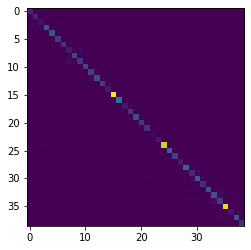

In [0]:
import torch
import helper
import numpy as np
import pandas as pd
from torch import nn
import seaborn as sn
from torch import optim
from itertools import cycle
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn import svm, datasets
import torchvision.models as models
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from torchvision import datasets, transforms, models
from sklearn.model_selection import train_test_split


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = models.vgg16(pretrained=True)

for param in model.parameters():
    param.requires_grad = True

model.classifier = nn.Sequential(nn.Linear(25088, 4096),
                                 nn.ReLU(),
                                 nn.Dropout(0.4),
                                 nn.Linear(4096,4096),
                                 nn.ReLU(),
                                 nn.Dropout(0.4),
                                 nn.Linear(4096,39),
                                 nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()

optimizer = optim.Adam(model.classifier.parameters(), lr = 0.00008)

model.to(device); 
                
epochs = 10
valid_loss_min = np.Inf # track change in validation loss
#steps = 0
#print_every = 5

#output = torch.randn(batch_size, n_classes) # refer to output after softmax
target = torch.randint(0, n_classes, (batch_size,)) # labels

def confusion_matrix(preds, labels, conf_matrix, title='Confusion matrix', cmap=plt.cm.Blues):
    preds = torch.argmax(preds, 1)
    for p, t in zip(preds, labels):
        conf_matrix[p, t] += 1

    #print(conf_matrix)
    #plt.imshow(conf_matrix)
    TP = conf_matrix.diag()
    for c in range(n_classes):
        idx = torch.ones(n_classes).byte()
        idx[c] = 0
        TN = conf_matrix[idx.nonzero()[:,None], idx.nonzero()].sum()
        FP = conf_matrix[c, idx].sum()
        FN = conf_matrix[idx, c].sum()

        Recall = (TP[c] / (TP[c]+FN))
        precision = (TP[c] / (TP[c]+FP))
        f1 = (2 * ((precision * Recall)/(precision + Recall)))

        #print('Class {}\nTP {}, TN {}, FP {}, FN {}'.format(c, TP[c], TN, FP, FN))
        #print('Sensitivity = {}'.format(sensitivity))
        #print('Specificity = {}'.format(specificity))
            
    return conf_matrix

conf_matrix = torch.zeros(n_classes, n_classes)

for epoch in range(1, epochs+1):
  
  train_loss = 0
  model.train()
  import warnings
  warnings.filterwarnings("ignore", category=UserWarning)
  for images, labels in dataloader_train:
    
    #steps += 1
    images, labels = images.to(device), labels.to(device)
    
    optimizer.zero_grad()
    
    output = model.forward(images)
    conf_matrix = confusion_matrix(output, labels, conf_matrix)
    p = torch.nn.functional.softmax(output, dim=1)
    prediction = torch.argmax(p, dim=1)
    #loss = torch.nn.functional.nll_loss(torch.log(p), y)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    
    train_loss += loss.item()*images.size(0)
    
    #vis.line(X=torch.ones((1,1)).cpu()*epoch, Y=torch.Tensor([train_loss]).unsqueeze(0).cpu(),win=loss_window,update='append')    
    
  #if steps % print_every == 0:
  valid_loss = 0
  accuracy = 0
  model.eval()
  #print(conf_matrix)
  TP = conf_matrix.diag()
  for c in range(n_classes):
      idx = torch.ones(n_classes).byte()
      idx[c] = 0
      TN = conf_matrix[idx.nonzero()[:,None], idx.nonzero()].sum()
      FP = conf_matrix[c, idx].sum()
      FN = conf_matrix[idx, c].sum()

      Recall = (TP[c] / (TP[c]+FN))
      precision = (TP[c] / (TP[c]+FP))
      f1 = (2 * ((precision * Recall)/(precision + Recall)))
      
      #print('Class {}\nTP {}, TN {}, FP {}, FN {}'.format(c, TP[c], TN, FP, FN))
      #print('Sensitivity = {}'.format(sensitivity))
      #print('Specificity = {}'.format(specificity))
    #return TP[C], TN, FP, FN, sensitivity, specificity
  
  for images, labels in dataloader_test:
    optimizer.zero_grad()
    with torch.no_grad():
       
      images, labels = images.to(device), labels.to(device)
      #if train_on_gpu:
      #      images, labels = data.cuda(), target.cuda()

      output = model.forward(images)
      conf_matrix = confusion_matrix(output, labels, conf_matrix)
      p = torch.nn.functional.softmax(output, dim=1)
      prediction = torch.argmax(p, dim=1)
      loss = criterion(output, labels)
          
      valid_loss += loss.item()*images.size(0)
      
      ps = torch.exp(output)
         
      top_p, top_class = ps.topk(1, dim = 1)
      equals = top_class == labels.view(*top_class.shape)
      accuracy += torch.mean(equals.type(torch.FloatTensor))
      
  # calculate average losses
  train_loss = train_loss/len(dataloader_train.dataset)
  valid_loss = valid_loss/len(dataloader_test.dataset)
        
  # print training/validation statistics 
  print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
  # save model if validation loss has decreased
  if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss
  
  print(conf_matrix)
  plt.imshow(conf_matrix)
  TP = conf_matrix.diag()
  for c in range(n_classes):
      idx = torch.ones(n_classes).byte()
      idx[c] = 0
      TN = conf_matrix[idx.nonzero()[:,None], idx.nonzero()].sum()
      FP = conf_matrix[c, idx].sum()
      FN = conf_matrix[idx, c].sum()

      Recall = (TP[c] / (TP[c]+FN))
      precision = (TP[c] / (TP[c]+FP))
      f1 = (2 * ((precision * Recall)/(precision + Recall)))
      
      print('Class {}\nTP {}, TN {}, FP {}, FN {}'.format(c, TP[c], TN, FP, FN))
      print('Recall = {}'.format(Recall))
      print('Precision = {}'.format(precision))
      print('F1 Score = {}'.format(f1))
  #print("Epoch: {}/{} " .format(epoch+1, epochs))
  #print("Train loss: {:.4f}.. " .format(running_loss/len(dataloader_train)))
  #print("Valid loss: {:.4f}.. " .format(valid_loss/len(dataloader_test)))
  print("Accuracy: {:.4f}.. " .format(accuracy/len(dataloader_test)))
  model.train()